In [1]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk; nltk.download('stopwords')
import re
from nltk.corpus import stopwords

nltk.download('vader_lexicon')
import seaborn as sns
import matplotlib.pyplot as plt
import smart_open

from gensim.models.coherencemodel import CoherenceModel

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alici\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alici\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Text Preprocessing And Feature Engineering (User Reviews)

In [2]:
df = pd.read_csv('../Data_Files/Raw_Data/users_reviews_20users_final.csv')
df.head(5)

,UserID,Title,Year,Review_Title,Review
0,ur117926588,Missing,2023,A solid follow-up to Searching that shows ther...,Having lost her father (Tim Griffin) to a brai...
1,ur117926588,Operation Fortune: Ruse de guerre,2023,Guy Ritchie returns to the spy genre with a fu...,"Following a theft of a device known as ""The Ha..."
2,ur117926588,Max,2015,A well made dog adventure story with considera...,"In the Kandahar Province of Afghanistan, Belig..."
3,ur117926588,The Night Agent,2023–,A fun intrigue rich conspiracy thriller anchor...,One year after thwarting a terrorist attack on...
4,ur117926588,New Nightmare,1994,Wes Craven celebrates the 10 year anniversary ...,10 years after the first A Nightmare on Elm St...


In [3]:
# identify duplicate rows based on 'userid' and 'title'
duplicate_mask = df.duplicated(subset=['UserID', 'Title'], keep=False)

# apply function to add year of release to the title for each duplicate row
df.loc[duplicate_mask, 'Title'] = df[duplicate_mask].apply(lambda x: f"{x['Title']} ({x['Year']})", axis=1)
df.drop_duplicates(['UserID', 'Title'], keep=False, inplace=True)
df.head(5)


,UserID,Title,Year,Review_Title,Review
0,ur117926588,Missing,2023,A solid follow-up to Searching that shows ther...,Having lost her father (Tim Griffin) to a brai...
1,ur117926588,Operation Fortune: Ruse de guerre,2023,Guy Ritchie returns to the spy genre with a fu...,"Following a theft of a device known as ""The Ha..."
2,ur117926588,Max,2015,A well made dog adventure story with considera...,"In the Kandahar Province of Afghanistan, Belig..."
3,ur117926588,The Night Agent,2023–,A fun intrigue rich conspiracy thriller anchor...,One year after thwarting a terrorist attack on...
4,ur117926588,New Nightmare,1994,Wes Craven celebrates the 10 year anniversary ...,10 years after the first A Nightmare on Elm St...


### Extract sentiment scores from reviews

In [4]:
# Create a SentimentIntensityAnalyzer object
analyzer = SentimentIntensityAnalyzer()

# Get the sentiment score as a dictionary with keys 'neg', 'neu', and 'pos'
# and values between 0 and 1 indicating the sentiment intensity

df['sentiment_score'] = df['Review_Title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df.head(5)

,UserID,Title,Year,Review_Title,Review,sentiment_score
0,ur117926588,Missing,2023,A solid follow-up to Searching that shows ther...,Having lost her father (Tim Griffin) to a brai...,0.1531
1,ur117926588,Operation Fortune: Ruse de guerre,2023,Guy Ritchie returns to the spy genre with a fu...,"Following a theft of a device known as ""The Ha...",0.5994
2,ur117926588,Max,2015,A well made dog adventure story with considera...,"In the Kandahar Province of Afghanistan, Belig...",0.5267
3,ur117926588,The Night Agent,2023–,A fun intrigue rich conspiracy thriller anchor...,One year after thwarting a terrorist attack on...,0.6705
4,ur117926588,New Nightmare,1994,Wes Craven celebrates the 10 year anniversary ...,10 years after the first A Nightmare on Elm St...,0.5719


### Extract topics from review title (Topic Modeling)

Preprocess review title

In [5]:
import gensim
from gensim.utils import simple_preprocess

stop_words = stopwords.words('english')
stop_words.extend(['film', 'movie', 'story'])

def preprocess(df, column):

    def sent_to_words(sentences):
        for sentence in sentences:
            # deacc=True removes punctuations
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) 
                if word not in stop_words] for doc in texts]

            
    # Remove punctuation
    df[f'{column}_processed'] = df[column].map(lambda x: re.sub('[,\.!?]', '', x))

    # Convert the titles to lowercase
    df[f'{column}_processed'] = df[f'{column}_processed'].map(lambda x: x.lower())

    data = df[f'{column}_processed'].values.tolist()
    data_words = list(sent_to_words(data))
    # remove stop words
    data_words = remove_stopwords(data_words)
    return data_words

data_words = preprocess(df, 'Review_Title')
print(data_words[:1][0][:30])

['solid', 'follow', 'searching', 'shows', 'plenty', 'life', 'screenlife', 'format']


In [6]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


Baseline LDA Model and LDA MultiCore

In [7]:
# Build LDA model

lda_model1 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model2 =  gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=15,  random_state=123)

Perplexity - Perplexity as well is one of the intrinsic evaluation metric, and is widely used for language model evaluation. It captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set.

Topic Coherence - Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

In [8]:

# Compute Perplexity
print('\nPerplexity for LDAModel: ', lda_model1.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_lda1 = CoherenceModel(model=lda_model1, texts=data_words, dictionary=id2word, coherence='c_v').get_coherence()
print('\nCoherence Score for LDAModel: ', coherence_lda1)


# Compute Perplexity
print('\nPerplexity for LDAMultiCore: ', lda_model2.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
coherence_lda2 = CoherenceModel(model=lda_model2, texts=data_words, dictionary=id2word, coherence='c_v').get_coherence()
print('\nCoherence Score for LDAMultiCore: ', coherence_lda2)


Perplexity for LDAModel:  -15.885168552281673

Coherence Score for LDAModel:  0.48413925935289576

Perplexity for LDAMultiCore:  -9.42530647395867

Coherence Score for LDAMultiCore:  0.2500348476279786


Since coherence score for LDA model is higher than LDAMultiCore, we will be using the LDAModel 

Evaluating Topic models

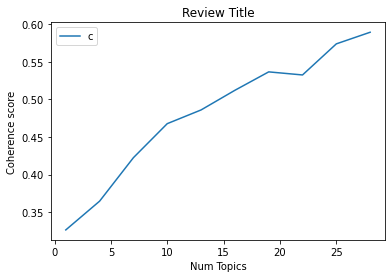

In [41]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =  gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=0)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=1, limit=30, step=3)

# Show graph
limit=30; start=1; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title("Review Title")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [45]:
from pprint import pprint

# Build LDA model
lda_model_final = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=0)
# # Print the Keyword in the 10 topics
# pprint(lda_model_final.print_topics())
doc_lda = lda_model_final[corpus]

In [46]:
pd.set_option('display.max_colwidth', -1)
topics = [[(term, round(wt, 3)) for term, wt in lda_model_final.show_topic(n, topn=20)] for n in range(0, lda_model_final.num_topics)]
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, lda_model_final.num_topics+1)] )
topics_df

c:\Users\alici\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Terms per Topic
Topic1,"long, back, man, life, emotional, old, come, ride, start, fantastic, works, hilarious, tarantino, adventure, watching, live, shows, sweet, might, ridiculous"
Topic2,"time, could, yet, flick, classic, weak, let, experience, worth, kids, every, action, class, bland, waste, go, series, better, still, wait"
Topic3,"much, nothing, favorite, better, see, expected, would, new, movies, absolutely, one, thrilling, personal, writing, keep, possibly, book, mind, ass, fantasy"
Topic4,"boring, acting, dull, dark, direction, going, two, intense, moving, without, epic, look, bond, chemistry, terrific, effort, stars, quality, rather, cool"
Topic5,"action, original, quite, sequel, plot, remake, packed, save, dumb, touch, loud, magic, plenty, tense, edge, christmas, hit, minutes, enthralling, charm"
Topic6,"well, made, lacking, big, even, something, exciting, tedious, everything, found, brutal, written, title, fascinating, bleak, tv, show, somewhat, mediocre, acted"
Topic7,"interesting, perfect, ending, get, thought, stuff, people, right, flawed, slasher, underrated, hell, getting, worst, romantic, got, lacks, world, want, provoking"
Topic8,"love, watch, amazing, masterpiece, better, script, forgettable, first, mess, wonderful, twist, predictable, gets, comedy, everyone, director, western, around, star, rate"
Topic9,"fine, end, real, clever, entertainment, kind, strange, less, simple, form, keeps, non, gives, though, debut, performance, stylish, day, put, night"
Topic10,"thriller, decent, entertaining, beautiful, bit, action, family, heart, fi, mystery, sci, unique, suspense, character, scenes, war, style, king, little, weird"


In [47]:
pd.reset_option('all')
# Get topic labels for each document
topic_labels = [max(lda_model_final[doc], key=lambda x:x[1])[0] for doc in corpus]
df['topic_labels_review'] = topic_labels
df['topic_keywords_review'] = df.topic_labels_review.apply(lambda x: [word for word, prob in lda_model_final.show_topic(x)])
df.head(5)

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



c:\Users\alici\anaconda3\lib\site-packages\pandas\_config\config.py:630: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
c:\Users\alici\anaconda3\lib\site-packages\pandas\_config\config.py:630: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


,UserID,Title,Year,Review_Title,Review,sentiment_score,Review_Title_processed,topic_labels_review,topic_keywords_review
0,ur117926588,Missing,2023,A solid follow-up to Searching that shows ther...,Having lost her father (Tim Griffin) to a brai...,0.1531,a solid follow-up to searching that shows ther...,0,"[long, back, man, life, emotional, old, come, ..."
1,ur117926588,Operation Fortune: Ruse de guerre,2023,Guy Ritchie returns to the spy genre with a fu...,"Following a theft of a device known as ""The Ha...",0.5994,guy ritchie returns to the spy genre with a fu...,2,"[much, nothing, favorite, better, see, expecte..."
2,ur117926588,Max,2015,A well made dog adventure story with considera...,"In the Kandahar Province of Afghanistan, Belig...",0.5267,a well made dog adventure story with considera...,5,"[well, made, lacking, big, even, something, ex..."
3,ur117926588,The Night Agent,2023–,A fun intrigue rich conspiracy thriller anchor...,One year after thwarting a terrorist attack on...,0.6705,a fun intrigue rich conspiracy thriller anchor...,3,"[boring, acting, dull, dark, direction, going,..."
4,ur117926588,New Nightmare,1994,Wes Craven celebrates the 10 year anniversary ...,10 years after the first A Nightmare on Elm St...,0.5719,wes craven celebrates the 10 year anniversary ...,2,"[much, nothing, favorite, better, see, expecte..."


# Text Preprocessing (User Rating)

In [48]:
df2 = pd.read_csv('../Data_Files/Raw_Data/users_ratings_img_20users_final.csv')
df2.head(5)

,UserID,Title,Img_Path,Img_File_Name,Year,Description,Directors,Stars,Viewer_Advisory,Duration,...,Color2,Color3,Brightness,Contrast,Saturation,Hue,Texture,Entropy,Noise,Colorfulness
0,ur3223254,The Making of 'West Side Story',https://m.media-amazon.com/images/M/MV5BOTU3Mj...,ur3223254_1.jpg,1985,"A documentary which shows, in great detail, th...",['Christopher Swann'],"['Leonard Bernstein', 'Kiri Te Kanawa', 'José ...",Not Rated,1 hr 29 min,...,"[197.87346221441118, 183.76742823667269, 147.5...","[132.63642065649162, 67.00731758310732, 66.696...",28.345112,1.0,0.483944,0.286751,0.095318,5.033725,2607.615256,0.151818
1,ur3223254,West Side Story,https://m.media-amazon.com/images/M/MV5BMzQ5ZD...,ur3223254_2.jpg,2021,"An adaptation of the 1957 musical, West Side S...",['Steven Spielberg'],"['Ansel Elgort', 'Rachel Zegler', 'Ariana DeBo...",PG-13,2 hr 36 min,...,"[192.77984157334174, 164.10516252390104, 156.2...","[26.031522737713317, 18.571141479099744, 27.59...",56.452657,1.0,0.387084,0.630909,0.117362,7.215298,2937.235783,0.105448
2,ur3223254,Supernova,https://m.media-amazon.com/images/M/MV5BNDc0Y2...,ur3223254_3.jpg,2020,Sam and Tusker are traveling across England in...,['Harry Macqueen'],"['Colin Firth', 'Stanley Tucci', 'Pippa Haywoo...",R,1 hr 35 min,...,"[237.4783657256323, 234.21676833593577, 225.24...","[192.77753168450687, 143.20118124769283, 122.0...",129.423365,1.0,0.336827,0.314486,0.064798,7.568517,5491.649326,0.239863
3,ur3223254,The Many Saints of Newark,https://m.media-amazon.com/images/M/MV5BYmQzNm...,ur3223254_4.jpg,2021,Witness the making of Tony Soprano. The story ...,['Alan Taylor'],"['Alessandro Nivola', 'Leslie Odom Jr.', 'Jon ...",R,2 hr,...,"[227.23344529750602, 227.37020153551038, 227.3...","[123.22488696677817, 87.70277177118118, 88.950...",59.251703,1.0,0.147507,0.146196,0.076623,6.669963,6147.526922,0.116340
4,ur3223254,Never Look Away,https://m.media-amazon.com/images/M/MV5BNGUwYT...,ur3223254_5.jpg,2018,German artist Kurt Barnert has escaped East Ge...,['Florian Henckel von Donnersmarck'],"['Tom Schilling', 'Sebastian Koch', 'Paula Bee...",R,3 hr 9 min,...,"[215.23204559848062, 185.4957568081067, 188.98...","[129.6641665391094, 101.77100872493492, 107.88...",95.750548,1.0,0.333741,0.614238,0.074675,7.714849,4981.923137,0.151493


In [49]:
# identify duplicate rows based on 'userid' and 'title'
duplicate_mask = df2.duplicated(subset=['UserID', 'Title'], keep=False)

# apply function to add year of release to the title for each duplicate row
df2.loc[duplicate_mask, 'Title'] = df2[duplicate_mask].apply(lambda x: f"{x['Title']} ({x['Year']})", axis=1)
df2.drop_duplicates(['UserID', 'Title'], keep=False, inplace=True)

df2 = df2[['UserID', 'Title', 'Description', 'Year']]
df2['Title'] = df2['Title'].fillna(' ')
df2['Description'] = df2['Description'].fillna(' ')
df2['title_desc'] = df2['Title'] + ' '+ df2['Description']
data_words = preprocess(df2, 'title_desc')

import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 2)]


In [50]:
# df2[df2.duplicated(['UserID', 'Title'], keep = False)]
len(df2)

37798

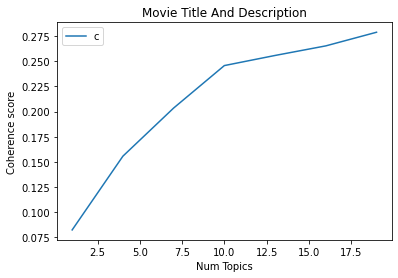

In [52]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =  gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=1, limit=20, step=3)

# Show graph
limit=20; start=1; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title("Movie Title And Description")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [53]:
from pprint import pprint

# Build LDA model
lda_model_desc = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=123)
# # Print the Keyword in the 10 topics
# pprint(lda_model_final.print_topics())
doc_lda = lda_model_desc[corpus]

pd.set_option('display.max_colwidth', -1)
topics = [[(term, round(wt, 3)) for term, wt in lda_model_desc.show_topic(n, topn=20)] for n in range(0, lda_model_desc.num_topics)]
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, lda_model_desc.num_topics+1)] )
topics_df

c:\Users\alici\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


,Terms per Topic
Topic1,"must, world, stop, old, earth, year, two, evil, race, war, family, time, back, young, alien, homer, man, girl, star, becomes"
Topic2,"one, life, daughter, find, new, jack, young, girl, family, penny, father, takes, former, rock, save, discover, crime, dead, woman, tries"
Topic3,"family, life, big, one, home, scientist, man, town, wife, father, boy, young, police, girl, dexter, get, finds, american, back, night"
Topic4,"new, man, city, family, must, one, police, help, batman, york, detective, death, life, young, bang, killer, revenge, cop, go, agent"
Topic5,"group, new, man, find, town, life, world, one, must, city, save, finds, house, mysterious, order, small, young, way, home, monsters"
Topic6,"life, four, man, love, young, murder, woman, show, becomes, new, two, falls, jones, family, john, miami, relationship, high, girlfriend, husband"
Topic7,"two, agent, theory, high, school, best, american, us, friend, young, serial, trip, killer, fbi, man, tries, three, help, team, spy"
Topic8,"world, war, life, young, new, two, family, man, ii, boy, friends, american, machine, next, park, three, robin, woman, son, love"
Topic9,"young, man, time, woman, new, school, find, future, high, life, world, love, three, sent, los, angeles, ship, one, team, game"
Topic10,"two, christmas, school, adventure, superhero, walt, dragon, young, robot, teacher, family, time, perfect, friends, mr, vacation, dance, summer, unaware, ice"


In [59]:
pd.reset_option('all')
# Get topic labels for each document
topic_labels = [max(lda_model_desc[doc], key=lambda x:x[1])[0] for doc in corpus]
df2['topic_labels_desc'] = topic_labels
df2['topic_desc_keywords'] = df2.topic_labels_desc.apply(lambda x: [word for word, prob in lda_model_desc.show_topic(x)])
df2.head(5)

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



c:\Users\alici\anaconda3\lib\site-packages\pandas\_config\config.py:630: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
c:\Users\alici\anaconda3\lib\site-packages\pandas\_config\config.py:630: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


,UserID,Title,Description,Year,title_desc,title_desc_processed,topic_labels_desc,topic_desc_keywords
0,ur3223254,The Making of 'West Side Story',"A documentary which shows, in great detail, th...",1985,The Making of 'West Side Story' A documentary ...,the making of 'west side story' a documentary ...,3,"[new, man, city, family, must, one, police, he..."
1,ur3223254,West Side Story (2021),"An adaptation of the 1957 musical, West Side S...",2021,West Side Story (2021) An adaptation of the 19...,west side story (2021) an adaptation of the 19...,5,"[life, four, man, love, young, murder, woman, ..."
2,ur3223254,Supernova,Sam and Tusker are traveling across England in...,2020,Supernova Sam and Tusker are traveling across ...,supernova sam and tusker are traveling across ...,1,"[one, life, daughter, find, new, jack, young, ..."
3,ur3223254,The Many Saints of Newark,Witness the making of Tony Soprano. The story ...,2021,The Many Saints of Newark Witness the making o...,the many saints of newark witness the making o...,9,"[two, christmas, school, adventure, superhero,..."
4,ur3223254,Never Look Away,German artist Kurt Barnert has escaped East Ge...,2018,Never Look Away German artist Kurt Barnert has...,never look away german artist kurt barnert has...,6,"[two, agent, theory, high, school, best, ameri..."


In [60]:
df_text = pd.merge(df2, df, on = ['UserID', 'Title','Year'], how = 'left')

# One Hot Encoding of Topics

In [61]:
# apply one hot encoding
one_hot_desc = pd.get_dummies(df_text['topic_labels_desc'], prefix='desc_topic_')
one_hot_review = pd.get_dummies(df_text['topic_labels_review'], prefix='review_topic_')

# concatenate the one hot encoded columns to the original dataframe
df_text = pd.concat([df_text, one_hot_desc, one_hot_review], axis=1)
df_text.head(5)

,UserID,Title,Description,Year,title_desc,title_desc_processed,topic_labels_desc,topic_desc_keywords,Review_Title,Review,...,review_topic__5.0,review_topic__6.0,review_topic__7.0,review_topic__8.0,review_topic__9.0,review_topic__10.0,review_topic__11.0,review_topic__12.0,review_topic__13.0,review_topic__14.0
0,ur3223254,The Making of 'West Side Story',"A documentary which shows, in great detail, th...",1985,The Making of 'West Side Story' A documentary ...,the making of 'west side story' a documentary ...,3,"[new, man, city, family, must, one, police, he...",The iconic masterpiece performed the way the c...,For those who treasure the impact of WEST SIDE...,...,0,0,1,0,0,0,0,0,0,0
1,ur3223254,West Side Story (2021),"An adaptation of the 1957 musical, West Side S...",2021,West Side Story (2021) An adaptation of the 19...,west side story (2021) an adaptation of the 19...,5,"[life, four, man, love, young, murder, woman, ...",NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,ur3223254,Supernova,Sam and Tusker are traveling across England in...,2020,Supernova Sam and Tusker are traveling across ...,supernova sam and tusker are traveling across ...,1,"[one, life, daughter, find, new, jack, young, ...","'Being sad when something is gone, just means ...",Actor/writer/director Harry Macqueen is gifted...,...,0,0,0,0,0,0,0,0,0,1
3,ur3223254,The Many Saints of Newark,Witness the making of Tony Soprano. The story ...,2021,The Many Saints of Newark Witness the making o...,the many saints of newark witness the making o...,9,"[two, christmas, school, adventure, superhero,...","Good intentions, deplorable presentation!",The concept of capturing the milieu and impact...,...,0,0,0,0,0,0,0,0,1,0
4,ur3223254,Never Look Away,German artist Kurt Barnert has escaped East Ge...,2018,Never Look Away German artist Kurt Barnert has...,never look away german artist kurt barnert has...,6,"[two, agent, theory, high, school, best, ameri...","'Don't look away. Never look away, Kurt. All t...","NEVER LOOK AWAY, titled in German Werk ohne au...",...,0,0,0,0,0,0,0,0,0,0


In [62]:
df_text.drop(columns = ['Description', 'title_desc', 'title_desc_processed', 'Year','topic_labels_desc', 'topic_desc_keywords','topic_labels_review', 'topic_keywords_review',"Review_Title", "Review", "Review_Title_processed"], inplace = True)
df_text.head(1)

,UserID,Title,sentiment_score,desc_topic__0,desc_topic__1,desc_topic__2,desc_topic__3,desc_topic__4,desc_topic__5,desc_topic__6,...,review_topic__5.0,review_topic__6.0,review_topic__7.0,review_topic__8.0,review_topic__9.0,review_topic__10.0,review_topic__11.0,review_topic__12.0,review_topic__13.0,review_topic__14.0
0,ur3223254,The Making of 'West Side Story',0.6249,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [63]:
df_text.to_csv('textual_features_cleaned.csv', index= False)